Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking, CmdStan
#gr(size=(600,600));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df);
first(df2, 5)

5×4 DataFrame
│ Row │ height  │ weight  │ age     │ male  │
│     │ Float64 │ Float64 │ Float64 │ Int64 │
├─────┼─────────┼─────────┼─────────┼───────┤
│ 1   │ 151.765 │ 47.8256 │ 63.0    │ 1     │
│ 2   │ 139.7   │ 36.4858 │ 63.0    │ 0     │
│ 3   │ 136.525 │ 31.8648 │ 65.0    │ 0     │
│ 4   │ 156.845 │ 53.0419 │ 41.0    │ 1     │
│ 5   │ 145.415 │ 41.2769 │ 51.0    │ 0     │

Define the Stan language model

In [5]:
weightsmodel = "
data {
 int < lower = 1 > N; // Sample size
 vector[N] height; // Predictor
 vector[N] weight; // Outcome
}

parameters {
 real alpha; // Intercept
 real beta; // Slope (regression coefficients)
 real < lower = 0 > sigma; // Error SD
}

model {
 height ~ normal(alpha + weight * beta , sigma);
}

generated quantities {
}
";

Define the Stanmodel and set the output format to :mcmcchains.

In [6]:
stanmodel = Stanmodel(name="weights", monitors = ["alpha", "beta", "sigma"],model=weightsmodel,
  output_format=:mcmcchains);

Input data for cmdstan

In [7]:
heightsdata = Dict("N" => length(df2[:height]), "height" => df2[:height],
  "weight" => df2[:weight]);

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at string:1
└ @ Core string:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at string:1
└ @ Core string:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at string:1
└ @ Core string:1


Sample using cmdstan

In [8]:
rc, chn, cnames = stan(stanmodel, heightsdata, ProjDir, diagnostics=false,
  summary=false, CmdStanDir=CMDSTAN_HOME)

(0, Object of type Chains, with data of type 1000×3×4 Array{Float64,3}

Iterations        = 1001:2000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
internals         = 
parameters        = alpha, beta, sigma

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean     │ std       │ naive_se    │ mcse       │ ess     │
│     │ Symbol     │ Float64  │ Float64   │ Float64     │ Float64    │ Any     │
├─────┼────────────┼──────────┼───────────┼─────────────┼────────────┼─────────┤
│ 1   │ alpha      │ 113.845  │ 1.91178   │ 0.0302279   │ 0.0490113  │ 1427.58 │
│ 2   │ beta       │ 0.905762 │ 0.0420781 │ 0.000665313 │ 0.00107317 │ 1424.64 │
│ 3   │ sigma      │ 5.10683  │ 0.186929  │ 0.00295561  │ 0.00481464 │ 1633.68 │

Quantiles

│ Row │ parameters │ 2.5%    │ 25.0%   │ 50.0%    │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64 │ Float64 │ Float64  │ Float64  │ Float64  │
├─────┼────────────┼───────

Show first 5 individual draws of correlated parameter values in chain 1

In [9]:
chn.value[1:5,:,1]

5×3 AxisArrays.AxisArray{Float64,2,Array{Float64,2},Tuple{AxisArrays.Axis{:iter,StepRange{Int64,Int64}},AxisArrays.Axis{:var,Array{String,1}}}}:
 114.009  0.896717  4.64164
 110.853  0.973446  4.82341
 114.411  0.894754  5.24203
 114.524  0.892121  5.12751
 114.565  0.888649  5.1233 

Plot estimates using the N = [10, 50, 150, 352] observations

In [10]:
p = Vector{Plots.Plot{Plots.GRBackend}}(undef, 4)
nvals = [10, 50, 150, 352];

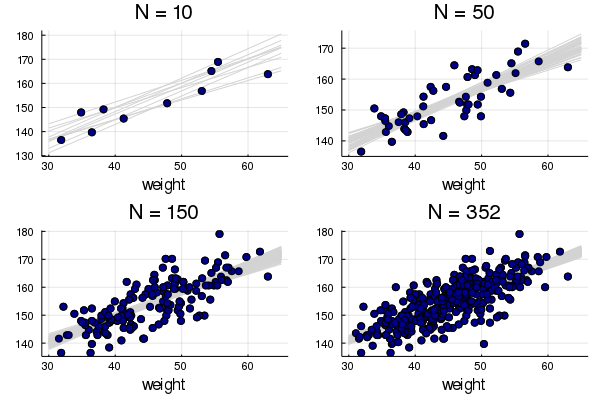

In [11]:
for i in 1:length(nvals)
  N = nvals[i]
  heightsdataN = [
    Dict("N" => N, "height" => df2[1:N, :height], "weight" => df2[1:N, :weight])
  ]
  rc, chnN, cnames = stan(stanmodel, heightsdataN, ProjDir, diagnostics=false,
    summary=false, CmdStanDir=CMDSTAN_HOME)

  xi = 30.0:0.1:65.0
  rws, vars, chns = size(chnN)
  alpha_vals = convert(Vector{Float64}, reshape(chnN.value[:, 1, :], (rws*chns)))
  beta_vals = convert(Vector{Float64}, reshape(chnN.value[:, 2, :], (rws*chns)))

  p[i] = scatter(df2[1:N, :weight], df2[1:N, :height], leg=false,
    color=:darkblue, xlab="weight")
  for j in 1:N
    yi = alpha_vals[j] .+ beta_vals[j]*xi
    plot!(p[i], xi, yi, title="N = $N", color=:lightgrey)
  end
  scatter!(p[i], df2[1:N, :weight], df2[1:N, :height], leg=false,
    color=:darkblue, xlab="weight")
end
plot(p..., layout=(2, 2))

End of `clip_45_47s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*